In [1]:
%matplotlib notebook

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import os
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState

import json

import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)



In [3]:
ticker         = params.ticker
save_path      = params.save_path

results_folder = "optuna results"              
n_trials = 90
n_jobs = 1

df_path = os.path.join(save_path, f"{ticker}_base.csv")
df = pd.read_csv(df_path, index_col=0, parse_dates=["datetime"])

df

,open,high,low,close,volume,ask,bid
datetime,,,,,,,
2014-04-03 10:42:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:43:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:04:00,28.6500,28.6500,28.6500,28.6500,11220.0,28.658595,28.641405
2014-04-03 11:05:00,28.6500,28.6500,28.6500,28.6500,4620.0,28.658595,28.641405
2014-04-03 11:34:00,28.5005,28.5005,28.5005,28.5005,3460.0,28.509050,28.491950
...,...,...,...,...,...,...,...
2025-06-18 23:55:00,173.9000,173.9445,173.8670,173.8681,3136.0,173.920300,173.815900
2025-06-18 23:56:00,173.8200,173.9500,173.7900,173.9000,183.0,173.952200,173.847800
2025-06-18 23:57:00,173.9500,173.9500,173.8600,173.8601,240.0,173.912300,173.807900


In [4]:
def optimiz_function(df,
                    look_back,
                    min_prof_thr, 
                    max_down_prop, 
                    gain_tightening_factor, 
                    merging_retracement_thr, 
                    merging_time_gap_thr, 
                    smooth_win_sig, 
                    pre_entry_decay, 
                    short_penalty,
                    buy_threshold, 
                    trailing_stop_thresh 
                    ):

    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(df=df, 
                                              regular_start_shifted=dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back*2, 60)),
                                              regular_start=params.regular_start, 
                                              regular_end=params.regular_end)
    
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline(df_prep=df_prep, 
                                                  col_signal='signal_smooth',
                                                  col_action='signal_action',
                                                  min_prof_thr=min_prof_thr, 
                                                  max_down_prop=max_down_prop, 
                                                  gain_tightening_factor=gain_tightening_factor, 
                                                  smooth_win_sig=smooth_win_sig, 
                                                  pre_entry_decay=pre_entry_decay,
                                                  short_penalty=short_penalty,
                                                  buy_threshold=buy_threshold, 
                                                  trailing_stop_thresh=trailing_stop_thresh, 
                                                  merging_retracement_thr=merging_retracement_thr, 
                                                  merging_time_gap_thr=merging_time_gap_thr)
    
    sum_returns = np.sum([res[2]['Strategy Return ($)'] for res in full_sim_results.values()]) # just to check and confirm the results
    mean_returns = np.mean([res[2]['Strategy Return ($)'] for res in full_sim_results.values()]) # the metric that we use as a reference

    del full_sim_results
    gc.collect()
    
    print('sum_returns:', sum_returns)
    print('mean_returns:', mean_returns)

    return mean_returns, sum_returns


In [5]:

# === Objective Function ===
def objective(trial):
    # Suggest parameters to test.
    hyperpar = {
        "look_back" : trial.suggest_categorical("look_back", [30, 60, 90, 120]),
        "min_prof_thr": trial.suggest_float("min_prof_thr", 0.05, 0.9),
        "max_down_prop": trial.suggest_float("max_down_prop", 0.05, 0.9),
        "gain_tightening_factor": trial.suggest_float("gain_tightening_factor", 0.05, 0.5),
        "smooth_win_sig": trial.suggest_int("smooth_win_sig", 15, 60),
        "pre_entry_decay": trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty": trial.suggest_float("short_penalty", 0.01, 0.5),
        "buy_threshold": trial.suggest_float("buy_threshold", 0.01, 0.9),
        "trailing_stop_thresh": trial.suggest_float("trailing_stop_thresh", 0.05, 0.9),
        "merging_retracement_thr": trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr": trial.suggest_float("merging_time_gap_thr", 0.1, 1)   
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hyperpar}\n")
    
    # Run your strategy simulation with the current set of parameters.
    mean_returns, sum_returns = optimiz_function(
        df=df,
        look_back=hyperpar["look_back"],
        min_prof_thr=hyperpar["min_prof_thr"],
        max_down_prop=hyperpar["max_down_prop"],
        gain_tightening_factor=hyperpar["gain_tightening_factor"],
        smooth_win_sig=hyperpar["smooth_win_sig"],
        pre_entry_decay=hyperpar["pre_entry_decay"],
        short_penalty=hyperpar["short_penalty"],
        buy_threshold=hyperpar["buy_threshold"],
        trailing_stop_thresh=hyperpar["trailing_stop_thresh"],
        merging_retracement_thr=hyperpar["merging_retracement_thr"],
        merging_time_gap_thr=hyperpar["merging_time_gap_thr"]
    )
    
    return mean_returns



<IPython.core.display.Javascript object>

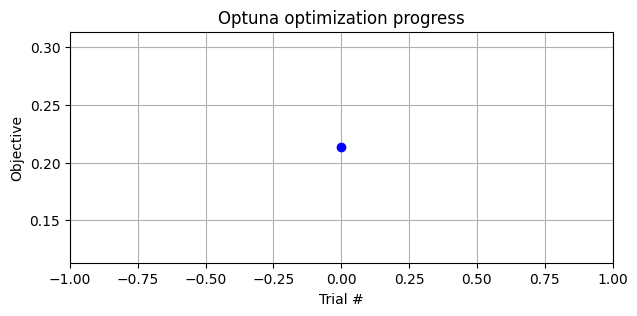

In [6]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

In [ ]:
# === Create and Run the Study ===
study = optuna.create_study(
    direction="maximize"
    # pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[live_cb],
)

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name:  <results_folder>/<TICKER>_<YYYYMMDD>-<YYYYMMDD>_optuna.json
# ------------------------------------------------------------------
start_date = df.index.min().strftime("%Y%m%d")
end_date   = df.index.max().strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signalpars.json"
file_path  = os.path.join(results_folder, file_name)

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")


[I 2025-07-22 17:34:42,158] A new study created in memory with name: no-name-cdfdc451-e250-4ea0-b0e8-602a9da419a1



▶ Trial 0 starting with:
{'look_back': 60, 'min_prof_thr': 0.586935793039662, 'max_down_prop': 0.26829304563833906, 'gain_tightening_factor': 0.2294329053997653, 'smooth_win_sig': 46, 'pre_entry_decay': 0.22283565074899264, 'short_penalty': 0.3345349450546222, 'buy_threshold': 0.598149370127141, 'trailing_stop_thresh': 0.8849390767034908, 'merging_retracement_thr': 0.434196648180346, 'merging_time_gap_thr': 0.7846818529715117}

 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


[I 2025-07-22 17:36:11,409] Trial 0 finished with value: 0.21326318383440118 and parameters: {'look_back': 60, 'min_prof_thr': 0.586935793039662, 'max_down_prop': 0.26829304563833906, 'gain_tightening_factor': 0.2294329053997653, 'smooth_win_sig': 46, 'pre_entry_decay': 0.22283565074899264, 'short_penalty': 0.3345349450546222, 'buy_threshold': 0.598149370127141, 'trailing_stop_thresh': 0.8849390767034908, 'merging_retracement_thr': 0.434196648180346, 'merging_time_gap_thr': 0.7846818529715117}. Best is trial 0 with value: 0.21326318383440118.


sum_returns: 432.711
mean_returns: 0.21326318383440118

▶ Trial 1 starting with:
{'look_back': 120, 'min_prof_thr': 0.3249145788284326, 'max_down_prop': 0.5423633912915461, 'gain_tightening_factor': 0.3714829690695538, 'smooth_win_sig': 50, 'pre_entry_decay': 0.1397976653714861, 'short_penalty': 0.34567608024031693, 'buy_threshold': 0.32304951706489826, 'trailing_stop_thresh': 0.7271497024864209, 'merging_retracement_thr': 0.4215593941006719, 'merging_time_gap_thr': 0.5069701004691382}

 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
